In [1]:
# %pip install -U lightgbm==3.3.2

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import pickle
from tqdm import tqdm
import gc
from pathlib import Path

In [2]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings("ignore")
sys.path.append("../src/") # path to the `src`` folder
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [3]:
from data import DataHelper
from data.metrics import map_at_k, hr_at_k, recall_at_k

from retrieval.rules import (
    OrderHistory,
    OrderHistoryDecay,
    ItemPair,

    UserGroupTimeHistory,
    UserGroupSaleTrend,

    TimeHistory,
    TimeHistoryDecay,
    SaleTrend,

    OutOfStock,
)
from retrieval.collector import RuleCollector

from features import cum_sale, week_sale, repurchase_ratio, purchased_before

from utils import calc_valid_date, merge_week_data, reduce_mem_usage, merge_new_groupings


In [4]:
data_dir = Path("../src/data/")

In [5]:
TRAIN_WEEK_NUM = 4
WEEK_NUM = TRAIN_WEEK_NUM + 2
VERSION_NAME = "pivot"# "v1"

In [6]:
import os
if not os.path.exists(data_dir/"interim"/VERSION_NAME):
    os.mkdir(data_dir/"interim"/VERSION_NAME)

In [7]:
TEST = True # * Set as `False` when do local experiments to save time

Pepare data: encoding ids and preprocessing

In [8]:
dh = DataHelper(data_dir)

In [9]:
# data = dh.preprocess_data(save=True, name="encoded_full") # * run only once, processed data will be saved

In [10]:
data = dh.load_data(name="encoded_full")

In [11]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

## Retrieval


Generate candidates for each week

In [12]:
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
data['user']['age_bins'] = pd.cut(data['user']['age'], listBin)

In [13]:
data['user']['age_bucket'] = pd.cut(data['user']['age'].fillna(22), [15, 24, 35, 50, 100], labels=[0, 1, 2, 3])

In [14]:
# # * WEEK_NUM = 0: test
# # * WEEK_NUM = 1: valid
# # * WEEK_NUM > 1: train

# for week in range(1, WEEK_NUM):
#     # * use sliding window to generate candidates
#     if week == 0 and not TEST:
#         continue
#     trans = data["inter"]

#     start_date, end_date = calc_valid_date(week)
#     print(f"Week {week}: [{start_date}, {end_date})")
    
#     last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
#     last_week_start = last_week_start.strftime("%Y-%m-%d")
    
#     last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
#     last_3day_start = last_3day_start.strftime("%Y-%m-%d")

#     train, valid = dh.split_data(trans, start_date, end_date)

#     last_week = train.loc[train.t_dat >= last_week_start]
#     last_week = last_week.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    
#     last_3days = train.loc[train.t_dat >= last_3day_start]
#     last_3days = last_3days.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    
#     train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

#     if week != 0:
#         customer_list = valid["customer_id"].values
#     else:
#         customer_list = submission['customer_id'].values

#     # * ========================== Retrieval Strategies ==========================

#     candidates = RuleCollector().collect(
#         valid = valid,
#         customer_list=customer_list,
#         rules=[
#             OrderHistory(train, 3),
#             OrderHistory(train, 7),
#             OrderHistoryDecay(train, 3, n=50),
#             OrderHistoryDecay(train, 7, n=50),
#             ItemPair(OrderHistory(train, 3).retrieve(), name='1'),
#             ItemPair(OrderHistory(train, 7).retrieve(), name='2'),
#             ItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),
#             ItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),
#             UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50, name='1'),
#             UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50, name='2'),
#             UserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50),
#             TimeHistory(customer_list, last_week, n=50, name='1'),
#             TimeHistory(customer_list, last_3days, n=50, name='2'),
#             TimeHistoryDecay(customer_list, train, 3, n=50),
#             TimeHistoryDecay(customer_list, train, 7, n=50),
#             SaleTrend(customer_list, train, 7, n=50),
#         ],
#         filters=[OutOfStock(trans)],
#         min_pos_rate=0.005,
#         compress=False,
#     )
    
#     candidates = (
#         pd.pivot_table(
#             candidates,
#             values="score",
#             index=["customer_id", "article_id"],
#             columns=["method"],
#             aggfunc=np.sum,
#         )
#         .reset_index()
#         # .fillna(0)
#     )

#     candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
#     if WEEK_NUM != 0:
#         valid.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_label.pqt")

In [15]:
# # * use the threshold in week 1 to generate candidates for test data, see the log in the upper cell 

# for week in range(1):
#     if week == 0 and not TEST:
#         continue
#     trans = data["inter"]

#     start_date, end_date = calc_valid_date(week)
#     print(f"Week {week}: [{start_date}, {end_date})")
    
#     last_5week_start = pd.to_datetime(start_date) - 5*pd.Timedelta(days=7)
#     last_5week_start = last_5week_start.strftime("%Y-%m-%d")
    
#     last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
#     last_week_start = last_week_start.strftime("%Y-%m-%d")
    
#     last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
#     last_3day_start = last_3day_start.strftime("%Y-%m-%d")

#     train, valid = dh.split_data(trans, start_date, end_date)
    
#     last_5week = train.loc[train.t_dat >= last_5week_start]
#     last_5week = last_5week.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

#     last_week = train.loc[train.t_dat >= last_week_start]
#     last_week = last_week.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    
#     last_3days = train.loc[train.t_dat >= last_3day_start]
#     last_3days = last_3days.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    
#     train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
#     last_5week = last_5week.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

#     if week != 0:
#         customer_list = valid["customer_id"].values
#     else:
#         customer_list = submission['customer_id'].values

#     # * ========================== Retrieval Strategies ==========================

#     candidates = RuleCollector().collect(
#         valid = valid,
#         customer_list=customer_list,
#         rules=[
#             OrderHistory(train, 3),
#             OrderHistory(train, 7),
#             OrderHistoryDecay(train, 3, n=50),
#             OrderHistoryDecay(train, 7, n=50),
#             ItemPair(OrderHistory(train, 3).retrieve(), name='1'),
#             ItemPair(OrderHistory(train, 7).retrieve(), name='2'),
#             ItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),
#             ItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),
#             UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=35, name='1'),
#             UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=38.5, name='2'),
#             UserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=3),
#             TimeHistory(customer_list, last_week, n=25, name='1'),
#             TimeHistory(customer_list, last_3days, n=30, name='2'),
#             TimeHistoryDecay(customer_list, train, 3, n=31),
#             TimeHistoryDecay(customer_list, train, 7, n=24),
#             SaleTrend(customer_list, train, 7, n=4),
#         ],
#         filters=[OutOfStock(trans)],
#         min_pos_rate=0.005,
#         compress=False,
#     )
    
#     candidates = (
#         pd.pivot_table(
#             candidates,
#             values="score",
#             index=["customer_id", "article_id"],
#             columns=["method"],
#             aggfunc=np.sum,
#         )
#         .reset_index()
#         # .fillna(0)
#     )

#     candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
#     if WEEK_NUM != 0:
#         valid.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_label.pqt")

In [16]:
# del train, valid, last_week, customer_list, candidates
# gc.collect()

## Feature engineering


In [17]:
user = data["user"]
item = data["item"]
inter = data["inter"]

In [18]:
# # merge `product_code`
# inter = inter.merge(item[["article_id", "product_code"]], on="article_id", how="left")
# # calculate week number
# inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7

In [19]:
# inter = inter.sort_values(["customer_id", "t_dat"]).reset_index(drop=True)

In [20]:
# inter.head()

In [21]:
# inter.shape

Week Sale

In [22]:
# inter["item_sale"] = week_sale(inter, ["article_id"])
# inter["pro_sale"] = week_sale(inter, ["product_code"])
# inter["item_sale_uni"] = week_sale(inter, ["article_id"], True)
# inter["pro_sale_uni"] = week_sale(inter, ["product_code"], True)
# inter["item_sale_ratio"] = inter["item_sale"] / (inter["pro_sale"] + 1e-6)
# inter["item_sale_uni_ratio"] = inter["pro_sale_uni"] / (inter["pro_sale_uni"] + 1e-6)

# inter = inter.merge(user[["customer_id", "age_bucket"]], on="customer_id", how="left")

# inter["item_sale_by_channel"] = week_sale(inter, ["article_id","sales_channel_id"])
# inter["pro_sale_by_channel"] = week_sale(inter, ["product_code","sales_channel_id"])
# inter["item_sale_uni_by_channel"] = week_sale(inter, ["article_id","sales_channel_id"], True)
# inter["pro_sale_uni_by_channel"] = week_sale(inter, ["product_code","sales_channel_id"], True)
# inter["item_sale_ratio_by_channel"] = inter["item_sale_by_channel"] / (inter["pro_sale_by_channel"] + 1e-6)
# inter["item_sale_uni_ratio_by_channel"] = inter["pro_sale_uni_by_channel"] / (inter["pro_sale_uni_by_channel"] + 1e-6)

# inter["item_sale_by_age"] = week_sale(inter, ["article_id","age_bucket"])
# inter["pro_sale_by_age"] = week_sale(inter, ["product_code","age_bucket"])
# inter["item_sale_uni_by_age"] = week_sale(inter, ["article_id","age_bucket"], True)
# inter["pro_sale_uni_by_age"] = week_sale(inter, ["product_code","age_bucket"], True)
# inter["item_sale_ratio_by_age"] = inter["item_sale_by_age"] / (inter["pro_sale_by_age"] + 1e-6)
# inter["item_sale_uni_ratio_by_age"] = inter["pro_sale_uni_by_age"] / (inter["pro_sale_uni_by_age"] + 1e-6)

# item_feats = [
#     "product_type_no",
#     "product_group_name",
#     "graphical_appearance_no",
#     "colour_group_code",
#     "perceived_colour_value_id",
#     "perceived_colour_master_id",
# ]
# inter = inter.merge(item[["article_id", *item_feats]], on="article_id", how="left")

# for feat in tqdm(item_feats):
#     inter[f"{feat}_sale"] = week_sale(inter, [feat], f"{feat}_sale")

# inter = inter.drop(columns=item_feats)

Repurchase Ratio

In [23]:
# inter['i_repurchase_ratio'] = repurchase_ratio(inter, ['article_id'])
# inter['p_repurchase_ratio'] = repurchase_ratio(inter, ['product_code'])

Already Bought Item

In [24]:
# inter["purchased_item"] = purchased_before(inter, ["article_id"])
# inter["purchased_pro"] = purchased_before(inter, ["product_code"])

Save data

In [25]:
# inter.shape

In [26]:
# inter.to_parquet(data_dir / "interim/processed_inter.pqt")
# inter.to_parquet(data_dir / "interim/processed_inter_v2.pqt")

## Merge Features


In [27]:
# candidates = {}
# for i in tqdm(range(WEEK_NUM)):
#     if i == 0 and not TEST:
#         continue
        
#     tmp_candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
#     candidates[i] = tmp_candidate

In [28]:
# inter = pd.read_parquet(data_dir / "interim/processed_inter.pqt")
# inter = pd.read_parquet(data_dir / "interim/processed_inter_v2.pqt")

In [29]:
# data["inter"] = inter
# data["inter"]['age_bucket'] = data["inter"]['age_bucket'].fillna(0).astype(int)

Merge features

In [30]:
# for i in tqdm(range(WEEK_NUM)):
#     if i in candidates:
#         candidates[i] = merge_week_data(data, i, candidates[i])

Merge user and item embeddings

In [31]:
# #* embedding from DSSM model
# dssm_user_embd = np.load(data_dir / "external/dssm_user_embd.npy", allow_pickle=True)
# dssm_item_embd = np.load(data_dir / "external/dssm_item_embd.npy", allow_pickle=True)

# for i in range(WEEK_NUM):
#     if i not in candidates:
#         continue
#     tmp = candidates[i]
#     sim = np.zeros(tmp.shape[0])
#     batch_size = 10000
#     for batch in tqdm(range(0, tmp.shape[0], batch_size)):
#         tmp_users = tmp.loc[batch : batch + batch_size - 1, 'customer_id'].values-1
#         tmp_items = tmp.loc[batch : batch + batch_size - 1, 'article_id'].values-1
#         tmp_user_embd = np.expand_dims(dssm_user_embd[tmp_users],1) # (batch_size, 1, dim)
#         tmp_item_embd = np.expand_dims(dssm_item_embd[tmp_items],2) # (batch_size, dim, 1)
#         tmp_sim = np.einsum('ijk,ikj->ij',tmp_user_embd,tmp_item_embd)
#         sim[batch : batch + batch_size] = tmp_sim.reshape(-1)
        
#     tmp["dssm_similarity"] = sim
#     candidates[i] = tmp

# del dssm_user_embd, dssm_item_embd
# gc.collect()

In [32]:
# # * embedding from YouTubeDNN model
# yt_user_embd = np.load(data_dir / "external/yt_user_embd.npy", allow_pickle=True)
# yt_item_embd = np.load(data_dir / "external/yt_item_embd.npy", allow_pickle=True)

# for i in range(WEEK_NUM):
#     if i not in candidates:
#         continue
#     tmp = candidates[i]
#     sim = np.zeros(tmp.shape[0])
#     batch_size = 10000
#     for batch in tqdm(range(0, tmp.shape[0], batch_size)):
#         tmp_users = tmp.loc[batch : batch + batch_size - 1, 'customer_id'].values-1
#         tmp_items = tmp.loc[batch : batch + batch_size - 1, 'article_id'].values-1
#         tmp_user_embd = np.expand_dims(yt_user_embd[tmp_users],1) # (batch_size, 1, dim)
#         tmp_item_embd = np.expand_dims(yt_item_embd[tmp_items],2) # (batch_size, dim, 1)
#         tmp_sim = np.einsum('ijk,ikj->ij',tmp_user_embd,tmp_item_embd)
#         sim[batch : batch + batch_size] = tmp_sim.reshape(-1)
        
#     tmp["yt_similarity"] = sim
#     # tmp["yt_similarity_cos"] = cos_sim
#     candidates[i] = tmp

# del yt_user_embd, yt_item_embd
# gc.collect()

In [33]:
# def merge_new_groupings(trans, week_num, candidates):
    
#     left_cols = ['t_dat', 'week', 'article_id', 'customer_id', 'age_bucket', 'item_sale_by_channel',
#                 'pro_sale_by_channel', 'item_sale_uni_by_channel',
#                 'pro_sale_uni_by_channel', 'item_sale_ratio_by_channel',
#                 'item_sale_uni_ratio_by_channel', 'item_sale_by_age', 'pro_sale_by_age',
#                 'item_sale_uni_by_age', 'pro_sale_uni_by_age', 'item_sale_ratio_by_age',
#                 'item_sale_uni_ratio_by_age']
    
#     trans = trans[left_cols].sort_values(by=["t_dat", "customer_id"]).reset_index(drop=True)
#     trans_info = (
#         trans[trans["week"] > week_num]
#         .groupby(["article_id"], as_index=False)
#         .last()
#         .drop(columns=["customer_id"])
#     )
#     trans_info["week"] = week_num
#     trans_info, _ = reduce_mem_usage(trans_info)

#     candidates = candidates.merge(trans_info.drop(['t_dat', 'week'], axis=1), on="article_id", how="left")
    
#     candidates, _ = reduce_mem_usage(candidates)

#     return candidates

In [34]:
# for i in tqdm(range(WEEK_NUM)):
#     if i in candidates:
#         candidates[i] = merge_new_groupings(data["inter"], i, candidates[i])

Save results

In [35]:
## for i in tqdm(range(WEEK_NUM)):
##     if i in candidates:
##         candidates[i] = candidates[i].drop(['t_dat_y', 'week_y'], axis=1)
##         candidates[i] = candidates[i].rename(columns={'t_dat_x':'t_dat', 'week_x':'week'})

In [36]:
# for i in tqdm(candidates.keys()):
#     candidates[i].to_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate_full.pqt")

## Ranking


In [49]:
article_cluster = pd.read_parquet(data_dir/'articles_new.parquet')
# https://www.kaggle.com/code/beezus666/k-means-and-feature-importance-for-articles/notebook?scriptVersionId=94269787

itemid2idx = pickle.load(open(data_dir/"index_id_map/item_id2index.pkl", "rb"))
article_cluster['article_id'] = article_cluster['article_id'].map(itemid2idx)

In [50]:
candidates = {}
labels = {}
for i in tqdm(range(WEEK_NUM)):
    if i==0 and not TEST:
        continue
    candidates[i] = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate_full.pqt")
    candidates[i] = candidates[i].merge(article_cluster[['article_id','colour_group_name_cat_cat_code',
                                                         'department_no', 'ct']],  on='article_id', how='left')
    
    candidates[i]['t_dat'] = pd.to_datetime(candidates[i]['t_dat'])
    candidates[i]['year'] = candidates[i]['t_dat'].dt.year
    candidates[i]['month'] = candidates[i]['t_dat'].dt.month
    candidates[i]['is_month_end'] = candidates[i]['t_dat'].dt.is_month_end
    candidates[i]['is_month_start'] = candidates[i]['t_dat'].dt.is_month_start

    if i != 0:
        tmp_label = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_label.pqt")
        labels[i] = tmp_label
    else:
        labels[i] = None
        
del article_cluster, itemid2idx

100%|██████████| 6/6 [05:19<00:00, 53.29s/it] 


In [51]:
feats = [
    x
    for x in candidates[1].columns
    if x
    not in [
        "label",
#         "sales_channel_id",
        "t_dat",
#         "week",
        "age",
        "WeekSaleTrend_item",
        "WeekSaleTrend_pro",
        "ThreeDaySaleTrend_item",
        "ThreeDaySaleTrend_pro",
    ]
]

cat_features = [
    "customer_id",
    "article_id",
    "product_code",
    "FN",
    "sales_channel_id",
    "Active",
    "club_member_status",
    "fashion_news_frequency",
#     "age",
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
    "age_bucket",
    "week",
    "year",
    "month",
    "is_month_end",
    "is_month_start"
]

In [52]:
# * convert categorical featues as `CategoricalDtype`
cate_dict = {f:set() for f in cat_features}
for i in tqdm(range(WEEK_NUM)):
    if i==0 and not TEST:
        continue
    for feat in cat_features:
        cate_dict[feat] = cate_dict[feat] | set(candidates[i][feat].unique())
        
for feat in cat_features:
    cate_dict[feat] = CategoricalDtype(categories=cate_dict[feat])

for i in tqdm(range(WEEK_NUM)):
    if i == 0 and not TEST:
        continue
    for feat in cat_features:
        candidates[i][feat] = candidates[i][feat].astype(cate_dict[feat])

100%|██████████| 6/6 [05:16<00:00, 52.77s/it] 


### Train


In [53]:
full_data = pd.concat(candidates[i] for i in range(1, WEEK_NUM))

In [54]:
train = full_data[full_data["week"] != 1]
valid = full_data[full_data["week"] == 1]
del full_data

In [55]:
# # * Remove customers with 0 hit_rate
# null_candidates = None
# for i in tqdm(range(WEEK_NUM)):
#     if i==0:
#         continue
#     tmp = pd.read_parquet(data_dir/"interim"/"v1"/f"week{i}_candidate.pqt")
#     tmp = tmp.groupby("customer_id")['hit_rate'].sum().reset_index()
#     tmp = tmp.loc[tmp['hit_rate']==0, ['customer_id']]
#     tmp['week'] = i
#     null_candidates = pd.concat([null_candidates, tmp], ignore_index=True)

# null_candidates['remove'] = 1
# train = pd.merge(train, null_candidates, on=['customer_id','week'], how='left')
# train = train[train['remove']!=1]
# del train['remove']
# train['customer_id'] = train['customer_id'].astype(cate_dict['customer_id'])

In [56]:
train = train.sort_values(by=['week', 'customer_id'],ascending=True).reset_index(drop=True)

train_group = train[["customer_id", "article_id", "week"]]
train_group = train_group.astype("int")
train_group = train_group.groupby(["week","customer_id"])['article_id'].count().values

In [59]:

# valid = candidates[1]
valid = valid.sort_values(by=['customer_id'],ascending=True).reset_index(drop=True)

valid_group = valid[["customer_id", "article_id"]]
valid_group = valid_group.astype("int")
valid_group = valid_group.groupby(["customer_id"])['article_id'].count().values

In [57]:
sum(train['label']==0) / len(train)
# 0.9946384702188372 4-week
# 0.994541076811467 4-week remove all-negative customer

0.9937720095316035

In [118]:
# params = {
#     "objective": "lambdarank",
#     "boosting_type": "gbdt",
#     "metric": "map",
#     "max_depth": 8,
#     "num_leaves": 555,
#     "learning_rate": 0.01,
#     "verbose": -1,
#     "eval_at": 12,
#     "lambdarank_truncation_level": 36,
#     "min_data_in_leaf": 63
# }

params = {
    "objective": "lambdarank",
    "boosting_type": "gbdt",
    "metric": "map",
    "max_depth": 8,
    "num_leaves": 128,
    "learning_rate": 0.01,
    "verbose": -1,
    "eval_at": 12,
}

In [121]:
feats

['customer_id',
 'article_id',
 'ItemPairRetrieve1',
 'ItemPairRetrieve2',
 'ItemPairRetrieve3',
 'ItemPairRetrieve4',
 'OrderHistoryDecay_3_top50',
 'OrderHistoryDecay_7_top50',
 'OrderHistory_3',
 'OrderHistory_7',
 'SaleTrend_7_top50',
 'TimeHistoryDecay_3_top50',
 'TimeHistoryDecay_7_top50',
 'TimeHistory_50_1',
 'TimeHistory_50_2',
 'UGTimeHistory_age_bins_501',
 'UGTimeHistory_age_bins_502',
 'price',
 'sales_channel_id',
 'product_code',
 'week',
 'item_sale',
 'pro_sale',
 'item_sale_uni',
 'pro_sale_uni',
 'item_sale_ratio',
 'item_sale_uni_ratio',
 'product_type_no_sale',
 'product_group_name_sale',
 'graphical_appearance_no_sale',
 'colour_group_code_sale',
 'perceived_colour_value_id_sale',
 'perceived_colour_master_id_sale',
 'i_repurchase_ratio',
 'p_repurchase_ratio',
 'purchased_item',
 'purchased_pro',
 'FN',
 'Active',
 'club_member_status',
 'fashion_news_frequency',
 'product_type_no',
 'product_group_name',
 'graphical_appearance_no',
 'colour_group_code',
 'percei

In [122]:
cat_features

['customer_id',
 'article_id',
 'product_code',
 'FN',
 'sales_channel_id',
 'Active',
 'club_member_status',
 'fashion_news_frequency',
 'product_type_no',
 'product_group_name',
 'graphical_appearance_no',
 'colour_group_code',
 'perceived_colour_value_id',
 'perceived_colour_master_id',
 'age_bucket',
 'week',
 'year',
 'month',
 'is_month_end',
 'is_month_start']

In [119]:
train_set = lgb.Dataset(
    data=train[feats],
    label=train["label"],
    group=train_group,
    feature_name=feats,
    categorical_feature=cat_features,
    params=params,
)

valid_set = lgb.Dataset(
    data=valid[feats],
    label=valid["label"],
    group=valid_group,
    feature_name=feats,
    categorical_feature=cat_features,
    params=params,
)

ranker = lgb.train(
    params,
    train_set,
    num_boost_round=300,
    valid_sets=[valid_set],
    early_stopping_rounds=30,
    verbose_eval=10
)

Training until validation scores don't improve for 30 rounds
[10]	valid_0's map@12: 0.763891
[20]	valid_0's map@12: 0.765715
[30]	valid_0's map@12: 0.766845
[40]	valid_0's map@12: 0.767012
[50]	valid_0's map@12: 0.766954
[60]	valid_0's map@12: 0.767059
[70]	valid_0's map@12: 0.767153
[80]	valid_0's map@12: 0.767197
[90]	valid_0's map@12: 0.767343
[100]	valid_0's map@12: 0.767206
[110]	valid_0's map@12: 0.767435
[120]	valid_0's map@12: 0.767552
[130]	valid_0's map@12: 0.767223
[140]	valid_0's map@12: 0.76729
[150]	valid_0's map@12: 0.767283
Early stopping, best iteration is:
[121]	valid_0's map@12: 0.767556


<Figure size 576x864 with 0 Axes>

<AxesSubplot:xlabel='importance', ylabel='feature'>

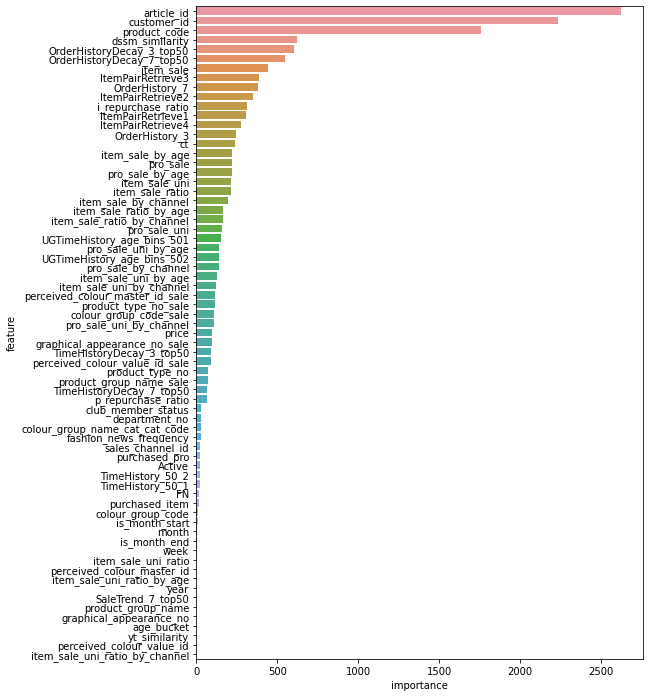

In [120]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 12))
sns.barplot(y="feature", x="importance", data=feat_importance)

In [44]:
ranker.save_model(data_dir / "interim/lgb_ranker.model", num_iteration=ranker.best_iteration)

### Inference

In [45]:
ranker = lgb.Booster(model_file=data_dir / "interim/lgb_ranker.model")

### Validate

In [63]:
val_candidates = valid.reset_index(drop=True)

In [88]:
probs = np.zeros(val_candidates.shape[0])
batch_size = 5_000_000
for batch in tqdm(range(0, val_candidates.shape[0], batch_size)):
    outputs = ranker.predict(val_candidates.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs

100%|██████████| 2/2 [00:08<00:00,  4.44s/it]


In [89]:
val_candidates["prob"] = probs

In [90]:
pred_lgb = val_candidates[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)

In [91]:
pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')

In [92]:
pred_lgb = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()

100%|██████████| 1371980/1371980 [04:09<00:00, 5490.09it/s]


In [93]:
label = labels[1]
label = pd.merge(label, pred_lgb, on="customer_id", how="left")

In [94]:
map_at_k(label["article_id"], label["prediction"], k=12)

# 0.02820525160663368 1-week add normalization
# 0.028936597823123886 4-week 0.0274
# 0.029111989281461418 4-week drop full-negative customer
# 0.029165419468984943 3-week 0.0270
# 0.028297597743100006 6 week 0.0250

# 0.02863472423766257 4 week
# 0.02882844782917304 4 week
# 0.028909064246733205 4 week
# 0.029366338019601947 4 week

0.029366338019601947

### Test

In [125]:
full_data = pd.concat(candidates[i] for i in range(1, WEEK_NUM))
train_ag = full_data

del full_data

In [126]:
train_ag = train_ag.sort_values(by=['week', 'customer_id'],ascending=True).reset_index(drop=True)

train_ag_group = train_ag[["customer_id", "article_id", "week"]]
train_ag_group = train_ag_group.astype("int")
train_ag_group = train_ag_group.groupby(["week","customer_id"])['article_id'].count().values

In [127]:
params = {
    "objective": "lambdarank",
    "boosting_type": "gbdt",
    "metric": "map",
    "max_depth": 8,
    "num_leaves": 128,
    "learning_rate": 0.01,
    "verbose": -1,
    "eval_at": 12,
}

train_ag_set = lgb.Dataset(
    data=train_ag[feats],
    label=train_ag["label"],
    group=train_ag_group,
    feature_name=feats,
    categorical_feature=cat_features,
    params=params,
)

ranker_ag = lgb.train(
    params,
    train_ag_set,
    num_boost_round=121,
    valid_sets=[train_ag_set],
    verbose_eval=10
)

[10]	training's map@12: 0.819237
[20]	training's map@12: 0.820026
[30]	training's map@12: 0.820287
[40]	training's map@12: 0.820511
[50]	training's map@12: 0.820685
[60]	training's map@12: 0.820875
[70]	training's map@12: 0.821112
[80]	training's map@12: 0.821273
[90]	training's map@12: 0.821479
[100]	training's map@12: 0.821656
[110]	training's map@12: 0.821777
[120]	training's map@12: 0.821992


<Figure size 576x864 with 0 Axes>

<AxesSubplot:xlabel='importance', ylabel='feature'>

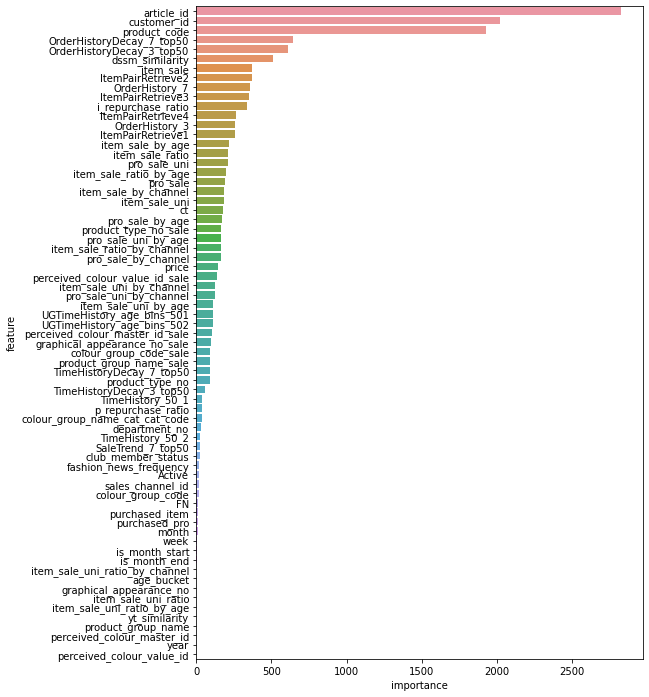

In [128]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker_ag.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 12))
sns.barplot(y="feature", x="importance", data=feat_importance)

In [129]:
ranker_ag.save_model(data_dir / "interim/lgb_ranker_ag.model")

In [130]:
ranker_ag = lgb.Booster(model_file=data_dir / "interim/lgb_ranker_ag.model")

In [131]:
test_candidates = candidates[0].reset_index(drop=True)

In [132]:
test_candidates.columns

Index(['customer_id', 'article_id', 'ItemPairRetrieve1', 'ItemPairRetrieve2',
       'ItemPairRetrieve3', 'ItemPairRetrieve4', 'OrderHistoryDecay_3_top50',
       'OrderHistoryDecay_7_top50', 'OrderHistory_3', 'OrderHistory_7',
       'SaleTrend_7_top4', 'TimeHistoryDecay_3_top31',
       'TimeHistoryDecay_7_top24', 'TimeHistory_25_1', 'TimeHistory_30_2',
       'UGSaleTrend_7_top3', 'UGTimeHistory_age_bins_351',
       'UGTimeHistory_age_bins_38.52', 't_dat', 'price', 'sales_channel_id',
       'product_code', 'week', 'item_sale', 'pro_sale', 'item_sale_uni',
       'pro_sale_uni', 'item_sale_ratio', 'item_sale_uni_ratio',
       'product_type_no_sale', 'product_group_name_sale',
       'graphical_appearance_no_sale', 'colour_group_code_sale',
       'perceived_colour_value_id_sale', 'perceived_colour_master_id_sale',
       'i_repurchase_ratio', 'p_repurchase_ratio', 'purchased_item',
       'purchased_pro', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age'

In [133]:
# As the threshold is set mannually when generating candidates for test set, we need to change the name of the columns
test_candidates.rename(columns = {
    'SaleTrend_7_top4':'SaleTrend_7_top50', 
    'TimeHistoryDecay_3_top31':'TimeHistoryDecay_3_top50',
    'TimeHistoryDecay_7_top24':'TimeHistoryDecay_7_top50',
    'TimeHistory_25_1':'TimeHistory_50_1', 
    'TimeHistory_30_2':'TimeHistory_50_2', 
    'UGSaleTrend_3_top2':'UGSaleTrend_7_top50', 
    'UGTimeHistory_age_bins_351':'UGTimeHistory_age_bins_501',
    'UGTimeHistory_age_bins_38.52':'UGTimeHistory_age_bins_502'
},inplace=True)

In [134]:
probs = np.zeros(test_candidates.shape[0])
batch_size = 5_000_000
for batch in tqdm(range(0, test_candidates.shape[0], batch_size)):
    outputs = ranker_ag.predict(test_candidates.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs

100%|██████████| 20/20 [03:36<00:00, 10.82s/it]


In [135]:
test_candidates["prob"] = probs

In [136]:
pred_lgb = test_candidates[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)

In [137]:
idx2uid = pickle.load(open(data_dir/"index_id_map/user_index2id.pkl", "rb"))
idx2iid = pickle.load(open(data_dir/"index_id_map/item_index2id.pkl", "rb"))

In [138]:
pred_lgb['prediction'] = pred_lgb['prediction'].map(idx2iid).progress_apply(lambda x:'0'+str(x))
pred_lgb = pred_lgb.groupby('customer_id')['prediction'].progress_apply(list).reset_index()
pred_lgb['prediction'] = pred_lgb['prediction'].progress_apply(lambda x: ' '.join(x[:12]))

100%|██████████| 1371980/1371980 [00:02<00:00, 497061.66it/s]


In [139]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

In [140]:
del submission['prediction']
submission = submission.merge(pred_lgb, on='customer_id', how='left')
submission['customer_id'] = submission['customer_id'].map(idx2uid)

In [141]:
submission.to_csv('submission.csv.gz', index=False)

In [142]:
submission.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0779781015 0568601043 0858856005 0918522001 09...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0918522001 0924243001 0918292001 0924243002 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0805000001 0918522001 0924243001 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0930380001 0918522001 0924243001 0924243002 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152001 0791587001 0927530006 0730683050 08...


### Submit

In [143]:
submit_msg = """
0.029366338019601947 4-week
---
OrderHistory(train, 3),
OrderHistory(train, 7),
OrderHistoryDecay(train, 3, n=50),
OrderHistoryDecay(train, 7, n=50),
ItemPair(OrderHistory(train, 3).retrieve(), name='1'),
ItemPair(OrderHistory(train, 7).retrieve(), name='2'),
ItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),
ItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),
UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),
UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),
UserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),
TimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),
TimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),
TimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),
TimeHistoryDecay(customer_list, train, 7, n=50 if week!=0 else 8),
SaleTrend(customer_list, train, 7, n=50 if week!=0 else 2)
---
min_pos_rate = 0.005 & cluster articles, groupings on channel & age, age bucket, month, year, 
month start, end, sales channel, removed age
pivot
"""

In [144]:
submit_msg

"\n0.029366338019601947 4-week\n---\nOrderHistory(train, 3),\nOrderHistory(train, 7),\nOrderHistoryDecay(train, 3, n=50),\nOrderHistoryDecay(train, 7, n=50),\nItemPair(OrderHistory(train, 3).retrieve(), name='1'),\nItemPair(OrderHistory(train, 7).retrieve(), name='2'),\nItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),\nItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),\nUserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),\nUserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),\nUserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),\nTimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),\nTimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),\nTimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),\nTimeHistoryDecay(customer_list, train, 7, n=50 if week!=0 else 8),\nSaleTre

In [145]:
! kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f "submission.csv.gz" -m '\n0.029111989281461418 4-week drop full negative user\n---\nOrderHistory(train, 3),\nOrderHistory(train, 7),\nOrderHistoryDecay(train, 3, n=50),\nOrderHistoryDecay(train, 7, n=50),\nItemPair(OrderHistory(train, 3).retrieve(), name='1'),\nItemPair(OrderHistory(train, 7).retrieve(), name='2'),\nItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),\nItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),\nUserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),\nUserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),\nUserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),\nTimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),\nTimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),\nTimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),\nTimeHistoryDecay(customer_list, train, 7, n=50 if week!=0 else 8),\nSaleTrend(customer_list, train, 7, n=50 if week!=0 else 2)\n---\nmin_pos_rate = 0.006\npivot\n'


100%|######################################| 66.2M/66.2M [00:03<00:00, 19.3MB/s]
Successfully submitted to H&M Personalized Fashion Recommendations